In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

In [2]:
envS = gym.make(
    'FrozenLake-v1',
    desc=None,
    map_name="4x4",
    is_slippery=True,
    success_rate=1.0/3.0,
    reward_schedule=(1, 0, 0)
)
envT = gym.make(
    'FrozenLake-v1',
    desc=None,
    map_name="4x4",
    is_slippery=False,
    success_rate=1.0/3.0,
    reward_schedule=(1, 0, 0)
)


In [3]:
def eGreedy(Q, epsilon):
    greedy = Greedy(Q)
    pi = epsilon*np.ones((16,4))/4.0 + (1-epsilon)*greedy
    return pi

def Greedy(Q):
    greedy = np.zeros((16,4))
    for s in range(16):
        q = Q[s]
        if np.linalg.norm(q) < 1e-8:
            greedy[s] = np.ones(4)/4.0
        else:
            greedy[s, np.argmax(Q[s])] = 1
    return greedy

In [4]:
def MonteCarloFV(env, seed, maxEpisodes, nsamples, epsilon, gamma):
    rng = np.random.default_rng(seed=hash(seed))
    totalSteps = 0
    Q = np.zeros((16,4))
    nvisit = np.zeros((16,4))
    pi = np.ones((16,4))/4.0
    samplePolicies = []
    sampleTimestamps = []
    episodesBetweenSamples = int(maxEpisodes/nsamples)
    for episode in range(int(maxEpisodes)):
        s, _ = env.reset()
        S = [s]
        A = []
        R = []
        term, trunc = False, False
        while not (term or trunc):
            a = rng.choice(4,p = pi[s])
            s, r, term, trunc, _ = env.step(a)
            totalSteps += 1
            S.append(s)
            A.append(a)
            R.append(r)
        G = 0
        S = np.array(S)
        A = np.array(A)
        R = np.array(R)
        for i in range(R.size):
            s, a = S[-2-i], A[-1-i]
            G = gamma*G+R[-1-i]
            # Check if this state-action pair is visited earlier in this rollout
            firstVisit = True
            Smask = S[:-2-i] == s
            Amask = A[:-1-i] == a
            for j in range(Smask.size):
                if Smask[j] and Amask[j]:
                    firstVisit = False
                    break
            if firstVisit:
                nvisit[s,a] +=1
                n = nvisit[s,a]
                Q[s,a] = Q[s,a]*(n-1)/n + G/n # update average directly
        pi = eGreedy(Q, max(0,epsilon*(1-(episode/maxEpisodes))))
        if episode % episodesBetweenSamples == episodesBetweenSamples -1:
            samplePolicies.append(Greedy(Q))
            sampleTimestamps.append(totalSteps)
    return Q, pi, totalSteps, np.array(samplePolicies), np.array(sampleTimestamps), nvisit

In [5]:
def SARSA(env, seed, maxEpisodes, nsamples, epsilon, gamma, alpha):
    rng = np.random.default_rng(seed=hash(seed))
    totalSteps = 0
    Q = np.zeros((16,4))
    nvisit = np.zeros((16,4))
    pi = np.ones((16,4))/4.0
    samplePolicies = []
    sampleTimestamps = []
    episodesBetweenSamples = int(maxEpisodes/nsamples)
    for episode in range(int(maxEpisodes)):
        s, _ = env.reset()
        a = rng.choice(4,p = pi[s])
        term, trunc = False, False
        while not (term or trunc):
            sn, r, term, trunc, _ = env.step(a)
            totalSteps += 1
            an = rng.choice(4,p = pi[sn])
            nvisit[s,a] += 1
            Q[s,a] = Q[s,a] + alpha*(r + gamma*Q[sn, an]-Q[s,a])
            pi = eGreedy(Q, max(0,epsilon*(1-1.25*episode/maxEpisodes)))
            s = sn
            a = an
        if episode % episodesBetweenSamples == episodesBetweenSamples -1:
            samplePolicies.append(np.copy(pi))
            sampleTimestamps.append(totalSteps)
    return Q, pi, totalSteps, np.array(samplePolicies), np.array(sampleTimestamps), nvisit

In [6]:
def QLearning(env, seed, maxEpisodes, nsamples, epsilon, gamma, alpha):
    rng = np.random.default_rng(seed=hash(seed))
    totalSteps = 0
    Q = np.zeros((16,4))
    nvisit = np.zeros((16,4))
    pi = np.ones((16,4))/4.0
    samplePolicies = []
    sampleTimestamps = []
    episodesBetweenSamples = int(maxEpisodes/nsamples)
    for episode in range(int(maxEpisodes)):
        s, _ = env.reset()
        term, trunc = False, False
        while not (term or trunc):
            a = rng.choice(4,p = pi[s])
            sn, r, term, trunc, _ = env.step(a)
            totalSteps += 1
            nvisit[s,a] += 1
            Q[s,a] = Q[s,a] + alpha*(r + gamma*Q[sn, np.argmax(Q[sn])]-Q[s,a])
            pi = eGreedy(Q, max(0,epsilon*(1-1.25*episode/maxEpisodes)))
            s = sn
        if episode % episodesBetweenSamples == episodesBetweenSamples -1:
            samplePolicies.append(np.copy(pi))
            sampleTimestamps.append(totalSteps)
    return Q, pi, totalSteps, np.array(samplePolicies), np.array(sampleTimestamps), nvisit

In [7]:
# This is supposed to be Q-learning with an additional off-policy Monte Carlo control update, but it's not working well
def HybridQLearningMC(env, seed, maxEpisodes, nsamples, epsilon, gamma, alpha):
    rng = np.random.default_rng(seed=hash(seed))
    totalSteps = 0
    Q = np.zeros((16,4))
    nvisit = np.zeros((16,4))
    pi = np.ones((16,4))/4.0
    samplePolicies = []
    sampleTimestamps = []
    episodesBetweenSamples = int(maxEpisodes/nsamples)
    for episode in range(int(maxEpisodes)):
        s, _ = env.reset()
        S = [s]
        A = []
        pA = []
        R = []
        term, trunc = False, False
        while not (term or trunc):
            a = rng.choice(4,p = pi[s])
            sn, r, term, trunc, _ = env.step(a)
            S.append(sn)
            A.append(a)
            pA.append(np.copy(pi[s,a]))
            R.append(r)
            totalSteps += 1
            nvisit[s,a] += 1
            Q[s,a] = Q[s,a] + alpha*(r + gamma*Q[sn, np.argmax(Q[sn])]-Q[s,a])
            pi = eGreedy(Q, max(0,epsilon*(1-1.25*episode/maxEpisodes)))
            s = sn
        mu = np.copy(pi)
        G = []
        g = 0
        S = np.array(S)
        A = np.array(A)
        pA = np.array(pA)
        R = np.array(R)
        for i in range(R.size):
            g = gamma*g+R[-1-i]
            G.append(g)
        G = np.array(G)
        for i in range(G.size):
            importance = G[-1-i]
            for j in range(i, G.size):
                s, a, pa = S[j], A[j], pA[j]
                importance *= pi[s,a]/pa
            Q[S[i], A[i]] = Q[S[i], A[i]] + alpha*(importance - Q[S[i], A[i]])
        pi = eGreedy(Q, max(0, epsilon*(1-1.25*episode/maxEpisodes)))
        if episode % episodesBetweenSamples == episodesBetweenSamples -1:
            samplePolicies.append(np.copy(pi))
            sampleTimestamps.append(totalSteps)
    return Q, pi, totalSteps, np.array(samplePolicies), np.array(sampleTimestamps), nvisit

In [8]:
# Train a policy multiple times
def MultiTrain(method, env, seed, MaxEpisodesPerTrainer, epsilon0, gamma, alpha, nSamplePolicies, nTrainers):
    TrainedPolicies = []
    TrainedQs = []
    TrainingSamplePolicies = []
    TrainingSampleTimestamps = []
    if not np.isin(method, np.array(["MonteCarlo","SARSA","QLearning","HybridQLearnMC"])):
        return
    for run in range(nTrainers):
        if method == "MonteCarlo":
            Q, pi, _, samplePolicies, sampleTimestamps, _ = MonteCarloFV(env, seed, MaxEpisodesPerTrainer, nSamplePolicies, epsilon0, gamma)
        elif method == "SARSA":
            Q, pi, _, samplePolicies, sampleTimestamps, _ = SARSA(env, seed, MaxEpisodesPerTrainer, nSamplePolicies, epsilon0, gamma, alpha)
        elif method == "QLearning":
            Q, pi, _, samplePolicies, sampleTimestamps, _ = QLearning(env, seed, MaxEpisodesPerTrainer, nSamplePolicies, epsilon0, gamma, alpha)
        elif method == "HybridQLearnMC":
            Q, pi, _, samplePolicies, sampleTimestamps, _ = HybridQLearningMC(env, seed, MaxEpisodesPerTrainer, nSamplePolicies, epsilon0, gamma, alpha)
        TrainedPolicies.append(pi)
        TrainedQs.append(Q)
        TrainingSamplePolicies.append(samplePolicies)
        TrainingSampleTimestamps.append(sampleTimestamps)
        seed += sampleTimestamps[-1] # Makes sure that the seed is different for each training run
    return method, np.array(TrainedPolicies), np.array(TrainedQs), np.array(TrainingSamplePolicies), np.array(TrainingSampleTimestamps)


# Evaluation return of a particular policy, function returns mean of discounted returns
def EvalReturn(pi, env, samples, gamma, seed):
    rng = np.random.default_rng(seed=hash(seed))
    Returns = []
    # Telemetry
    for sample in range(int(samples)):
        s, _ = env.reset()
        R = []
        term, trunc = False, False
        while not (term or trunc):
            a = rng.choice(4,p = pi[s])
            s, r, term, trunc, _ = env.step(a)
            R.append(r)
        G = 0
        for i in range(len(R)):
            G = gamma*G+R[-1-i]
        Returns.append(G)
    Returns = np.array(Returns)
    mean = np.mean(Returns)
    return mean

# Evaluation return of a set of policies, function returns mean and standard deviation of mean discounted returns
def EvalReturnMultiPolicy(PI, env, samples, gamma, seed):
    npi = PI.shape[0]
    Returns = []
    for pi in PI:
        runMean = EvalReturn(pi, env, samples, gamma, seed)
        Returns.append(runMean)
        seed = int(seed/(runMean+1))
    Returns = np.array(Returns)
    mean = np.mean(Returns)
    std = np.std(Returns)
    return mean, std

# Plot evalutaion return
def EvalReturnPlot(fig, ax, label, color, env, samples, gamma, TrainingSamplePolicies, TrainingSampleTimestamps):
    means = []
    stds = []
    TrainingTimes = np.sum(TrainingSampleTimestamps, axis=0) # Sum up steps taken up to when each policy was sampled
    for i in range(TrainingSamplePolicies.shape[1]):
        PolicySet = TrainingSamplePolicies[:,i] # Set of ith sample policies from each training run
        mean, std = EvalReturnMultiPolicy(PolicySet, env, samples, gamma, TrainingTimes[i])
        means.append(mean)
        stds.append(std)
    means = np.array(means)
    stds = np.array(stds)
    ax.plot(TrainingTimes, means, label=label, color=color)
    ax.fill_between(TrainingTimes, means-stds, means+stds, facecolor=color, alpha=0.3)

# plot policy
def PolicyPlot(pi, title):
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    for s in range(16):
        #          scale unit vectors of action directions by pi(s)      Offset by position of state
        aMapRaw = 0.5*(np.array([[-1,0],[0,1],[1,0],[0,-1]]).T*pi[s]).T + np.array([s%4, int(s/4)])
        # Create a closed loop of points for plotting
        aMap = np.zeros((5,2))
        aMap[:4] = aMapRaw
        aMap[4] = aMapRaw[0]
        ax.plot(aMap[:,0],aMap[:,1], color='k')
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim(3.6,-0.6)
    ax.set_xlim(-0.6,3.6)
    ax.yaxis.set_ticks([3,2,1,0])
    ax.xaxis.set_ticks([0,1,2,3])
    plt.savefig(title+".png")
    
    

In [9]:
seed = 20251006
dataSlippery = {}
dataTraction = {}
epsilon0 = 1
alpha = 0.4
gamma = 0.95
MaxEpisodesPerTrainer = 5e4
nSamplePolicies = 50
nTrainers = 10
EvalSamples = 50

methods = ["MonteCarlo", "SARSA", "QLearning"]
for method in methods:
    print("Training " + method + " with slippery=True")
    out = MultiTrain(method, envS, seed, MaxEpisodesPerTrainer, epsilon0, gamma, alpha, nSamplePolicies, nTrainers)
    dataSlippery[out[0]] = out[1:]
    print("Training " + method + " with slippery=False")
    out = MultiTrain(method, envT, seed, MaxEpisodesPerTrainer/10, epsilon0, gamma, alpha, nSamplePolicies, nTrainers)
    dataTraction[out[0]] = out[1:]

Training MonteCarlo with slippery=True
Training MonteCarlo with slippery=False
Training SARSA with slippery=True
Training SARSA with slippery=False
Training QLearning with slippery=True
Training QLearning with slippery=False


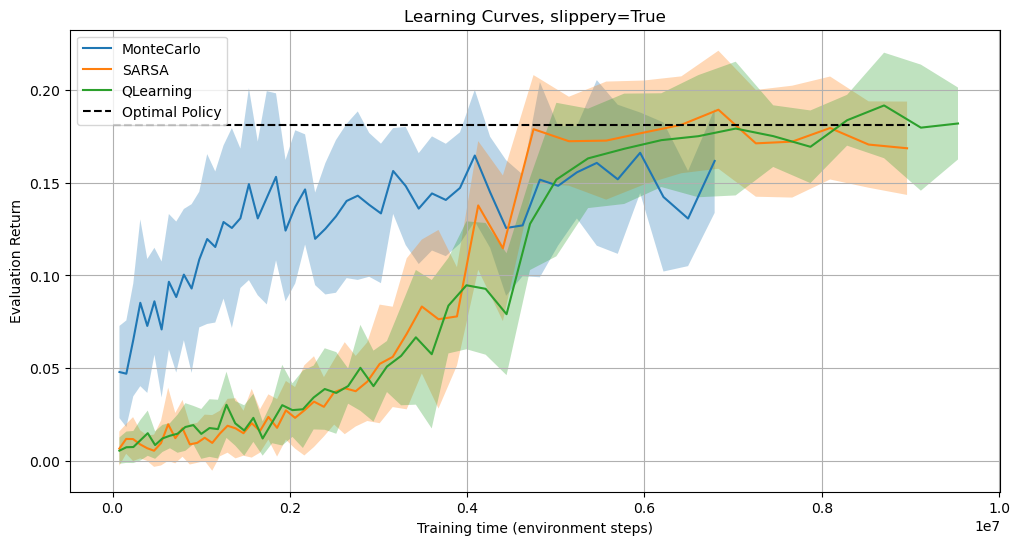

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.grid(True)
for method in methods:
    Policies, Qs, SamplePolicies, Timestamps = dataSlippery[method]
    if method == "MonteCarlo":
        color = "tab:blue"
    elif method == "SARSA":
        color = "tab:orange"
    elif method == "QLearning":
        color = "tab:green"
    else:
        color = "tab:red"
    EvalReturnPlot(fig, ax, method, color, envS, EvalSamples, gamma, SamplePolicies, Timestamps)
ax.plot([0,9e6],[0.1808828924448556,0.1808828924448556], label="Optimal Policy", linestyle="--", color="k")
ax.legend()
ax.set_ylabel("Evaluation Return")
ax.set_xlabel("Training time (environment steps)")
ax.set_title("Learning Curves, slippery=True")
plt.savefig("SlipperyTrainingCurve.png")

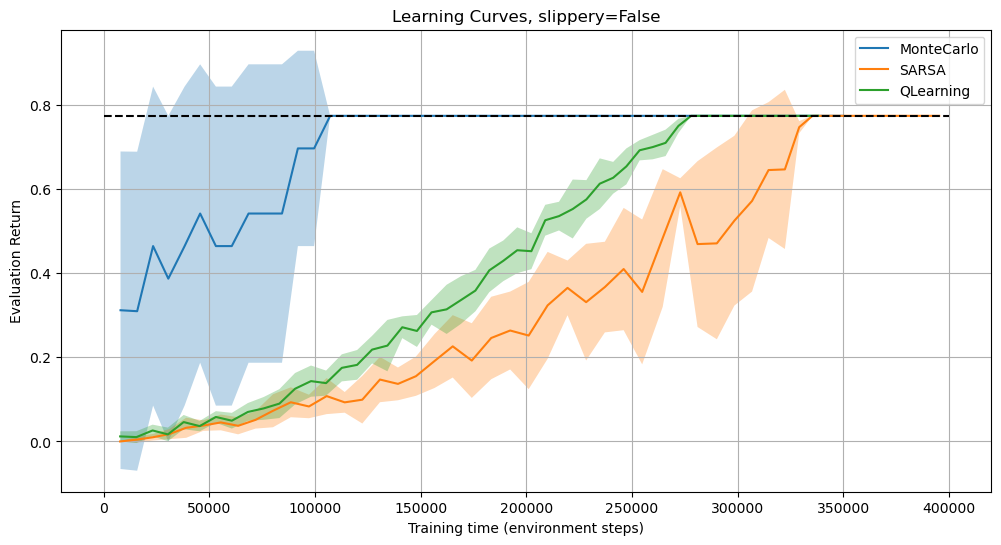

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.grid(True)
for method in methods:
    Policies, Qs, SamplePolicies, Timestamps = dataTraction[method]
    if method == "MonteCarlo":
        color = "tab:blue"
    elif method == "SARSA":
        color = "tab:orange"
    elif method == "QLearning":
        color = "tab:green"
    else:
        color = "tab:red"
    EvalReturnPlot(fig, ax, method, color, envT, EvalSamples, gamma, SamplePolicies, Timestamps)
ax.legend()
ax.plot([0,4e5],[0.7738,0.7738], label="Optimal Policy", linestyle="--", color="k")
ax.set_ylabel("Evaluation Return")
ax.set_xlabel("Training time (environment steps)")
ax.set_title("Learning Curves, slippery=False")
plt.savefig("TractionTrainingCurve.png")

C:\Users\caswe\AppData\Local\Temp\ipykernel_16476\1677191480.py:4: RuntimeWarning: invalid value encountered in divide
  AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)


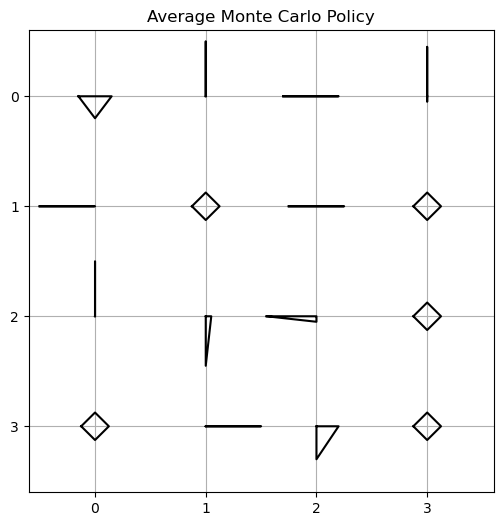

In [12]:
Policies, Qs, SamplePolicies, Timestamps = dataSlippery["MonteCarlo"]
AvgPolicy = np.sum(Policies, axis=0)/nTrainers
AvgQ = np.sum(Qs, axis=0)
AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)
PolicyPlot(AvgPolicy, "Average Monte Carlo Policy")
#PolicyPlot(AvgQ.T, "Average normalized Monte Carlo Value Function")

C:\Users\caswe\AppData\Local\Temp\ipykernel_16476\1111994471.py:4: RuntimeWarning: invalid value encountered in divide
  AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)


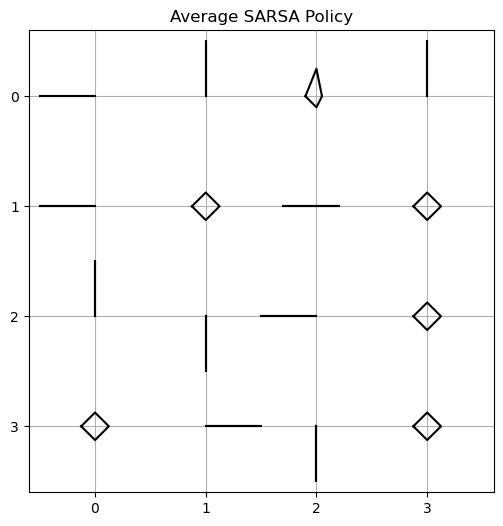

In [13]:
Policies, Qs, SamplePolicies, Timestamps = dataSlippery["SARSA"]
AvgPolicy = np.sum(Policies, axis=0)/nTrainers
AvgQ = np.sum(Qs, axis=0)
AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)
PolicyPlot(AvgPolicy, "Average SARSA Policy")
#PolicyPlot(AvgQ.T, "Average normalized SARSA Value Function")

C:\Users\caswe\AppData\Local\Temp\ipykernel_16476\4282790495.py:4: RuntimeWarning: invalid value encountered in divide
  AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)


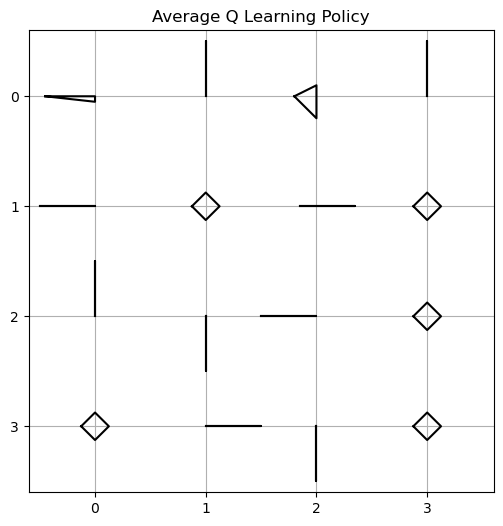

In [14]:
Policies, Qs, SamplePolicies, Timestamps = dataSlippery["QLearning"]
AvgPolicy = np.sum(Policies, axis=0)/nTrainers
AvgQ = np.sum(Qs, axis=0)
AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)
PolicyPlot(AvgPolicy, "Average Q Learning Policy")
#PolicyPlot(AvgQ.T, "Average normalized Q Learning Value Function")

C:\Users\caswe\AppData\Local\Temp\ipykernel_16476\2507504969.py:4: RuntimeWarning: invalid value encountered in divide
  AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)


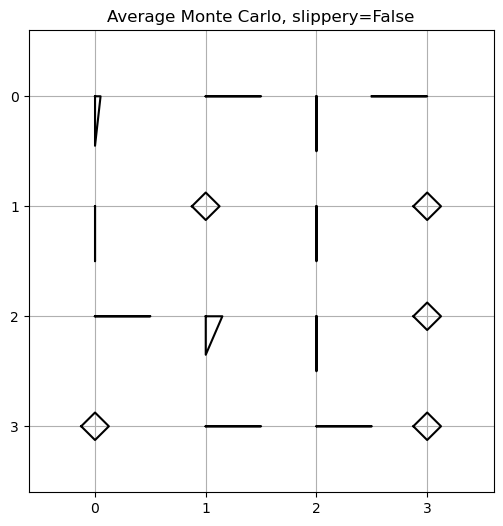

In [20]:
Policies, Qs, SamplePolicies, Timestamps = dataTraction["MonteCarlo"]
AvgPolicy = np.sum(Policies, axis=0)/nTrainers
AvgQ = np.sum(Qs, axis=0)
AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)
PolicyPlot(AvgPolicy, "Average Monte Carlo, slippery=False")
#PolicyPlot(AvgQ.T, "Average normalized Q Learning Value Function")

C:\Users\caswe\AppData\Local\Temp\ipykernel_16476\1046831824.py:4: RuntimeWarning: invalid value encountered in divide
  AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)


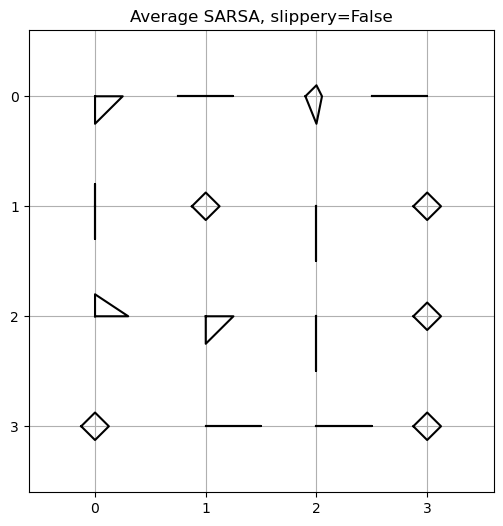

In [22]:
Policies, Qs, SamplePolicies, Timestamps = dataTraction["SARSA"]
AvgPolicy = np.sum(Policies, axis=0)/nTrainers
AvgQ = np.sum(Qs, axis=0)
AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)
PolicyPlot(AvgPolicy, "Average SARSA, slippery=False")
#PolicyPlot(AvgQ.T, "Average normalized Q Learning Value Function")

C:\Users\caswe\AppData\Local\Temp\ipykernel_16476\3658972828.py:4: RuntimeWarning: invalid value encountered in divide
  AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)


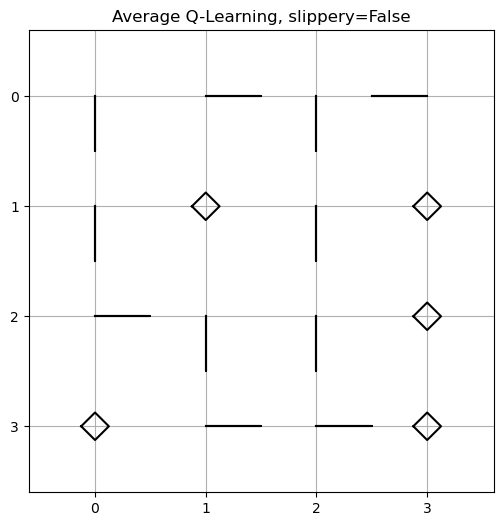

In [23]:
Policies, Qs, SamplePolicies, Timestamps = dataTraction["QLearning"]
AvgPolicy = np.sum(Policies, axis=0)/nTrainers
AvgQ = np.sum(Qs, axis=0)
AvgQ = AvgQ.T/np.sum(AvgQ, axis=1)
PolicyPlot(AvgPolicy, "Average Q-Learning, slippery=False")
#PolicyPlot(AvgQ.T, "Average normalized Q Learning Value Function")

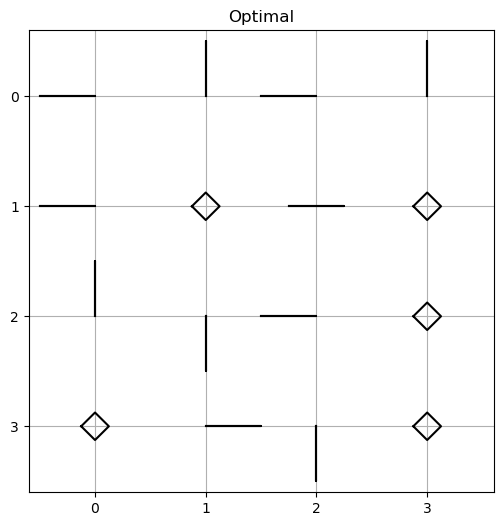

In [15]:
piOpt = np.array([[1,0,0,0],[0,0,0,1],[1,0,0,0],[0,0,0,1],
                  [1,0,0,0],[0.25,0.25,0.25,0.25],[.5,0,0.5,0],[0.25,0.25,0.25,0.25],
                  [0,0,0,1],[0,1,0,0],[1,0,0,0],[0.25,0.25,0.25,0.25],
                  [0.25,0.25,0.25,0.25],[0,0,1,0],[0,1,0,0],[0.25,0.25,0.25,0.25]])
PolicyPlot(piOpt,"Optimal")

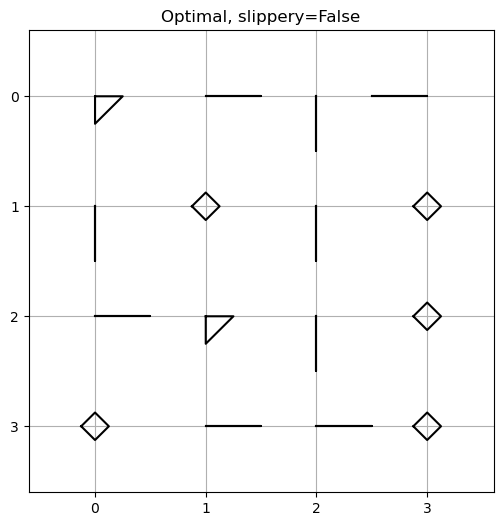

In [21]:
piOptT = np.array([[0,0.5,0.5,0],[0,0,1,0],[0,1,0,0],[1,0,0,0],
                  [0,1,0,0],[0.25,0.25,0.25,0.25],[0,1,0,0],[0.25,0.25,0.25,0.25],
                  [0,0,1,0],[0,0.5,0.5,0],[0,1,0,0],[0.25,0.25,0.25,0.25],
                  [0.25,0.25,0.25,0.25],[0,0,1,0],[0,0,1,0],[0.25,0.25,0.25,0.25]])
PolicyPlot(piOptT,"Optimal, slippery=False")

In [16]:
k = 200
PI = []
for i in range(k):
    PI.append(piOpt)
EvalReturnMultiPolicy(np.array(PI), envS, 200, 0.95, 20251006)

(0.1808828924448556, 0.01303952143082329)